# Search for Runaways



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

import sys
sys.path.append('..')

from locate_cluster_outliers.src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers
from locate_cluster_outliers.src.gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Load up Stars, Cluster Info

In [2]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [3]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members = list(known_cluster_members.query('Cluster == @cl').index)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(known_members)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'Coma Berenices Cluster':'ComaBer',
               'Pleiades':'Pleiades',
               'Praesepe': 'Praesepe',
               'alpha Per':'alphaPer',
               'IC 2391': 'IC2391',
               'IC 2602': 'IC2602',
               'Blanco 1': 'Blanco1',
               'NGC 2451A': 'NGC2451'}
cluster_info = querySIMBAD(name_mapper, formatGaia=True)

In [5]:
search_results = {}
for cl in cluster_names:
    ra_offset =  0*u.degree
    dec_offset = 0*u.degree
    search_radius = 13.0*u.degree

    ra = cluster_info.loc[cl]['coords'].ra + ra_offset
    dec = cluster_info.loc[cl]['coords'].dec + dec_offset
    
    dist = cluster_info.loc[cl]['coords'].distance.value
    minplx = 1000/(dist*1.25)
    maxplx = 1000/(dist*0.75)

    #grab some stars around the cluster center
    fs = gs(name=f'{cl} cone search', description=f'Conesearch around {cl}')

    fs.conesearch(ra, dec, search_radius, parallax=(minplx, maxplx))
    
    search_results[cl]= fs
    
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Pleiades cone search, Description: Conesearch around Pleiades, 9831 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: alphaPer cone search, Description: Conesearch around alphaPer, 13796 objects


In [6]:
#exclude the known members returned from the search
for cl in cluster_names:
    merged_fs = search_results[cl].merge(cluster_members[cl])
    print(f'------ {cl} -------')
    print(merged_fs.objs.which.value_counts())
    fs = merged_fs.query('which == \'{} cone search\''.format(cl))
    fs.name = 'Search Results, Known Members excluded'
    search_results[cl] = fs

------ Pleiades -------
Pleiades cone search    8857
both                     974
Pleiades                 352
Name: which, dtype: int64
------ alphaPer -------
alphaPer cone search    13211
both                      585
alphaPer                  155
Name: which, dtype: int64


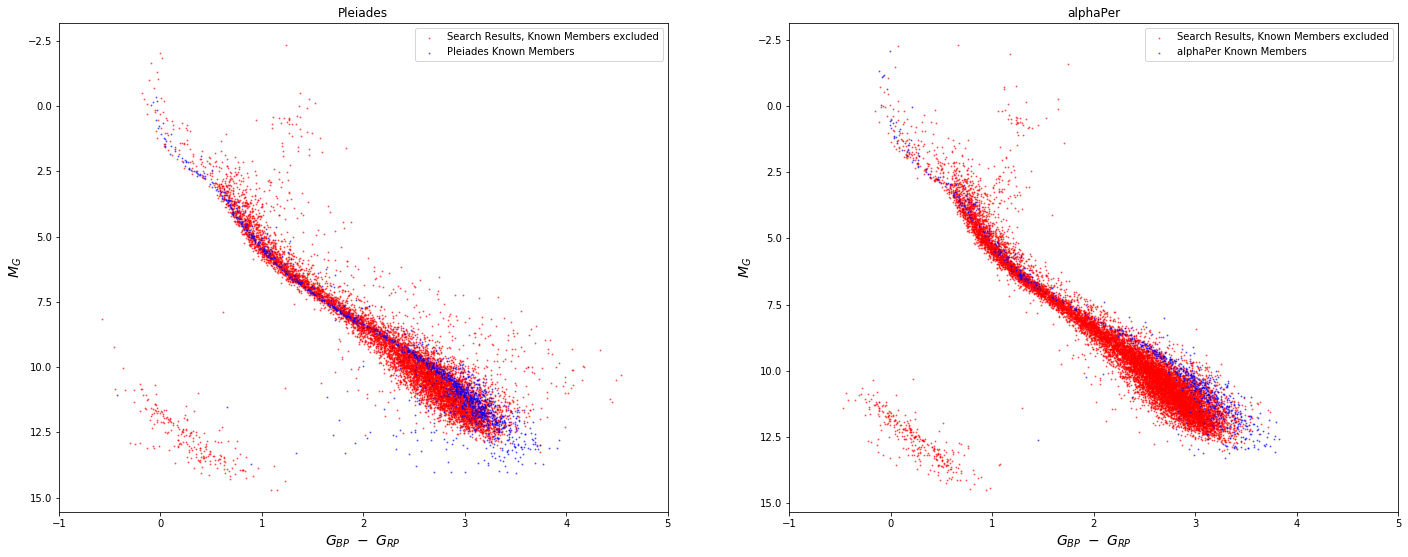

In [17]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='red', alpha=0.5, s=1)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members', alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()


## Evaluate `points_to` Relationship

In [8]:
for cl in cluster_names:
    maxsep = cluster_members[cl].maxsep() /2.0
    print(f'{cl}: Maxsep: {maxsep}')
    search_results[cl].points_to(cluster_info.loc[cl]['coords'],maxsep.value, inplace=True, allcalcs=False)



Pleiades: Maxsep: 3.3289846566877452 deg
alphaPer: Maxsep: 2.5454916248544937 deg


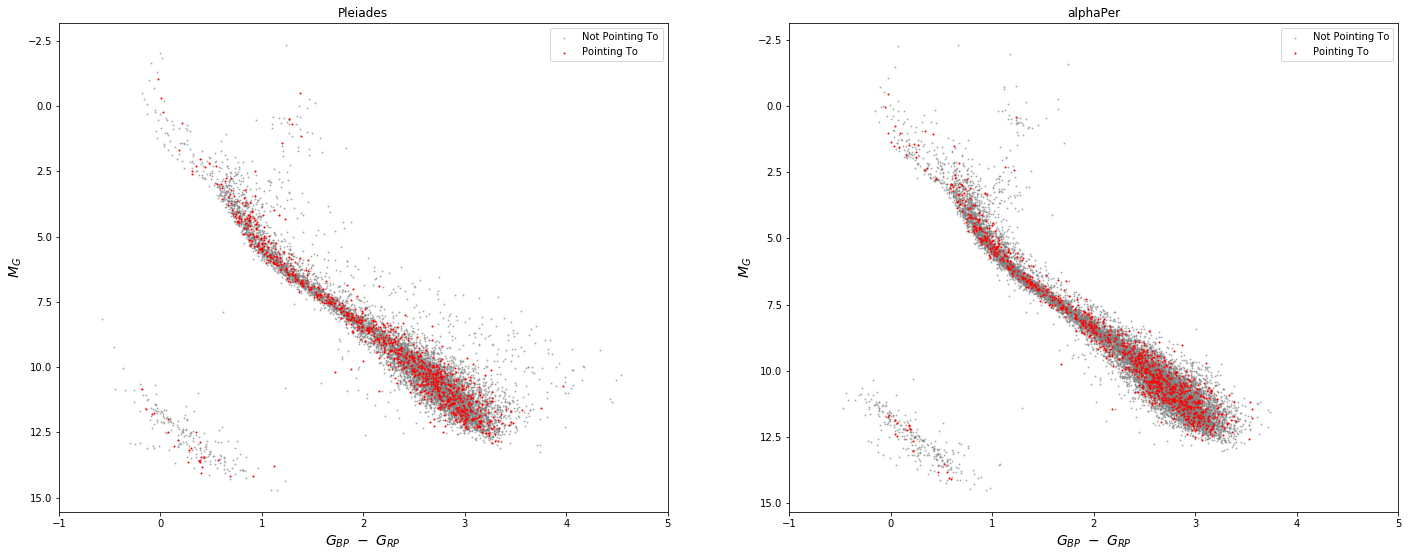

In [9]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('~PointsTo').plot_hrdiagram(ax=ax[i], color='grey', alpha=0.5, s=1, label="Not Pointing To")
    search_results[cl].query('PointsTo').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=1, label='Pointing To')
    ax[i].set_title(cl)
    ax[i].legend()

## Color Model

In [10]:
from locate_cluster_outliers.src.colormagmodel import cm_model

#fit the color models
cm_models = {}
for cl in cluster_names:
    cm_models[cl] = cm_model(f'{cl} Color Model')
    cm_models[cl].fit(*cluster_members[cl].get_colors())

In [12]:
tbt_thresh = 50e6 #minimum traceback time in years

for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] = np.logical_and(cm_ok, search_results[cl].objs.PointsTo)
    
    #apply age filter
    search_results[cl].objs['TBTok'] = np.logical_and(search_results[cl].objs.ColorMag, search_results[cl].objs.TraceBackTime >= tbt_thresh)

In [13]:
#summarize results
for cl in cluster_names:
    scores = np.array([search_results[cl].objs.PointsTo, search_results[cl].objs.ColorMag, search_results[cl].objs.TBTok]).sum(axis=0)
    search_results[cl].objs['Score'] = scores

## Plot Results

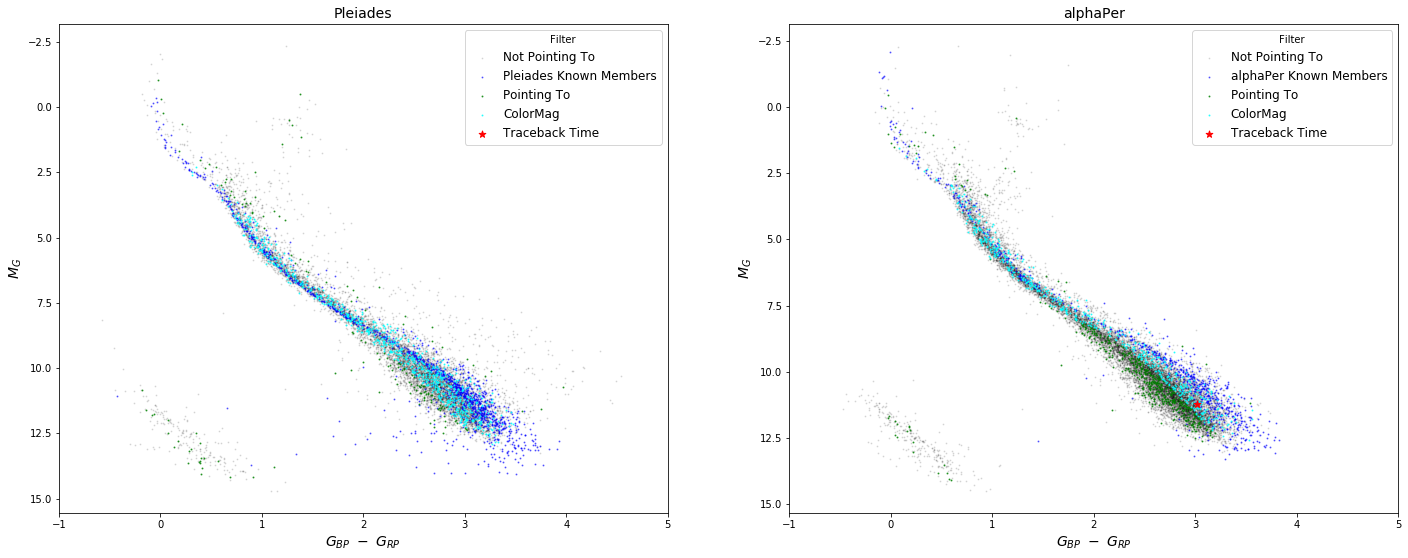

In [14]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('Score == 0').plot_hrdiagram(ax=ax[i], color='black', alpha=0.1, s=1, label="Not Pointing To")
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members', alpha=0.5, s=1)
    search_results[cl].query('Score == 1').plot_hrdiagram(ax=ax[i], color='green', alpha=0.7, s=1, label="Pointing To")
    search_results[cl].query('Score == 2').plot_hrdiagram(ax=ax[i], color='cyan', alpha=0.7, s=1, label="ColorMag")
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=50,marker='*', label="Traceback Time")

    ax[i].set_title(cl, fontsize=14)
    ax[i].legend(fontsize=12, title='Filter')

Text(0.5, 1.0, 'alphaPer Known Members and Candidate')

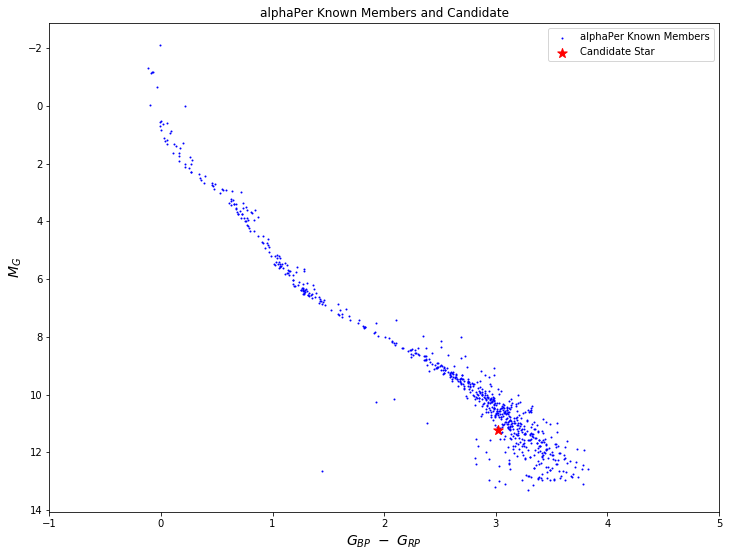

In [15]:
fig = plt.figure(figsize=(12,9))
ax = fig.subplots(1,1)

cl = 'alphaPer'
cluster_members[cl].plot_hrdiagram(ax=ax, color='blue', label=f'{cl} Known Members', alpha=1, s=1)
search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax, color='red', alpha=1, s=100,marker='*', label="Candidate Star")

ax.legend()
ax.set_title('alphaPer Known Members and Candidate')

In [16]:
search_results['alphaPer'].query('Score==3').objs

,_merge,which,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,...,e_bp_min_rp_val,a_g_val,r_est,Inbounds,WithinDist,PointsTo,TraceBackTime,ColorMag,TBTok,Score
source_id,,,,,,,,,,,,,,,,,,,,,
225062269204429952,left_only,alphaPer cone search,56.016248,40.642864,6.307031,23.766819,-26.945715,NaN,17.209068,18.94989,...,NaN,NaN,157.927481,True,True,True,5.258419e+07,True,True,3


In [18]:
#from locate_cluster_outliers.src.gaiastars import gaiastars as gs
from locate_cluster_outliers.src.plotting import make_square_axes, getTangentPoints, plot_points_to

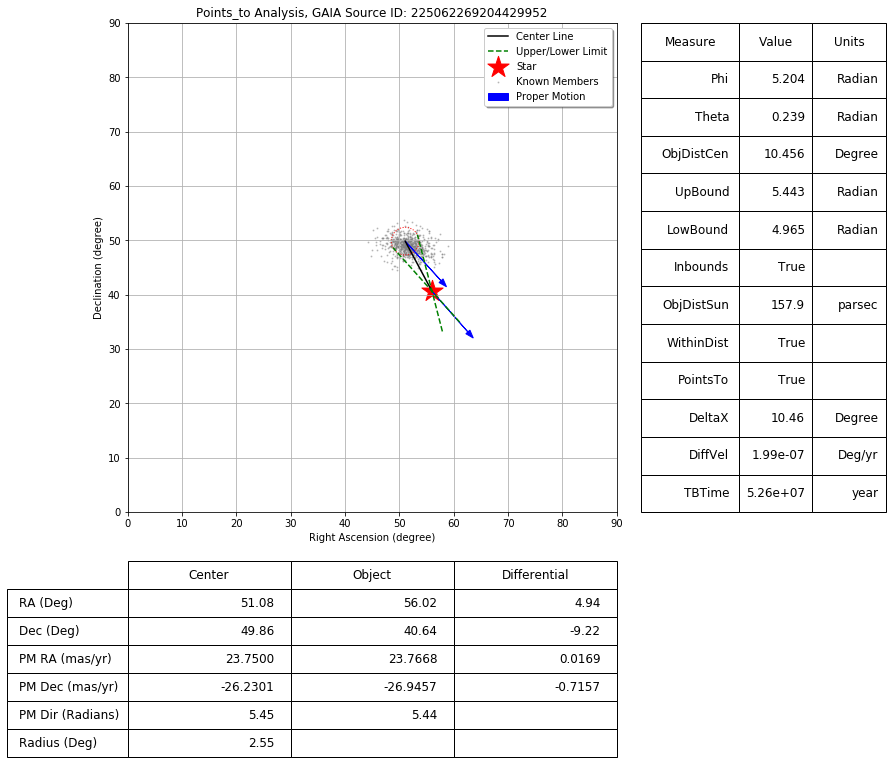

In [30]:
maxsep = cluster_members['alphaPer'].maxsep() /2.0
points_to = search_results['alphaPer'].points_to(cluster_info.loc['alphaPer']['coords'],maxsep.value, inplace=False, allcalcs=True)

i =search_results['alphaPer'].query('Score==3').objs.index[0]

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

plot_points_to(points_to.loc[i],cluster_members['alphaPer'], ax)
make_square_axes(ax)